In [ ]:
# import libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from PIL import Image

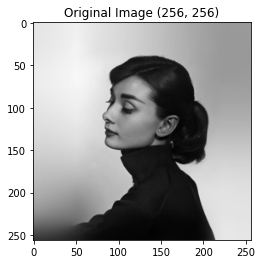

In [ ]:
# 1-(1). Get Gray level image; size N x N (512x512의 이미지 불러옴.)
N = 256
image = Image.open("/content/drive/MyDrive/Colab Notebooks/영상처리/datas/hepburn.jpg").resize((N, N)).convert('L')
original_f = np.array(image)
plt.imshow(original_f, cmap="gray", vmin=0, vmax=255 )
plt.title("Original Image " + str(original_f.shape))
plt.show()  # 이미지 출력

In [ ]:
# GetKxKs : NxN image to 8x8 (K=8) sub images
def GetKxKs(image, K=8):
  n = len(image)
  if n % K != 0: return
  ret = []
  for row in range(int(n/K)): 
    for col in range(int(n/K)):
      ret.append(image[row*K:(row+1)*K, col*K:(col+1)*K])
  return np.array(ret)

In [ ]:
# GetNxN : KxK(8x8) sub images to NxN image
def GetNxN(images):
  K = images.shape[1]
  N = int(np.sqrt(images.shape[0]) * K)
  ret_image = np.empty((N, N), float)
  for i in range(N):
    for j in range(N):
      group = int(i/K) * int(N/K) + int(j/K)
      ret_image[i][j] = images[group][i%K][j%K]
  return np.array(ret_image)

In [ ]:
# 1-(2). partition to 8*8 sub images
f_s = GetKxKs(original_f, 8)
print("8*8 서브 이미지들을 담은 f_s :", f_s.shape)

8*8 서브 이미지들을 담은 f_s : (1024, 8, 8)


In [ ]:
# Fourier Formular
def Fourier(N, x, a):
  return  complex(sp.cos((2. * sp.pi * x * a)/N), -1.*sp.sin((2. * sp.pi * x * a)/N))/np.sqrt(N)

# Inverse Fourier Formular
def IFourier(N, x, a):
  return  complex(sp.cos((2. * sp.pi * x * a)/N), +1.*sp.sin((2. * sp.pi * x * a)/N))/np.sqrt(N)

# 2-(1). Define DFT function T() and IDFT function IT()
# T : DFT (Discrete Fourier Transform)
def T(N):
  U = []
  for i in range(N):
    row = []
    for j in range(N):
      row.append(Fourier(N, i, j))
    U.append(row)
  return np.array(U)

# IT : IDFT (Inverse Discrete Fourier Transform)
def IT(N):
  U = []
  for i in range(N):
    row = []
    for j in range(N):
      row.append(IFourier(N, i, j))
    U.append(row)
  return np.array(U)

In [ ]:
# 2-(2) Derived Fs images Applying DFT to these sub image f_s.
# Fs : The 8*8 image F list in Frequency Domain
Fs = []
T8 = T(8)
for f in f_s:
  Fs.append(np.dot(T8, np.dot(f, np.matrix.getH(T8))))
Fs = np.array(Fs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


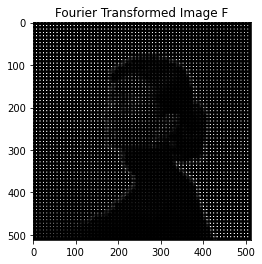

In [ ]:
# 2-(3) Get the fourier transformed image F
plt.imshow(abs(GetNxN(Fs)), cmap='gray', vmin=0, vmax=255 )
plt.title("Fourier Transformed Image F")
plt.show()

In [ ]:
# 3-(1). S : Subsampling matrix n*n -> n/2*n/2 in Spatial Domain
def S(n):
  ret = []
  for i in range(int(n/2)):
    row = []
    for j in range(n):
      if i*2 == j or (i*2 +1) == j:
        row.append(0.5)
      else: row.append(0)
    ret.append(row)
  return np.array(ret)

In [ ]:
# 3-(2). Derive the proper subsampling function matrix S in spatial domain
S = S(8)
print("S =", S)

S = [[0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5]]


In [ ]:
# 4-(1). Derive the frequency version of subsampling function matrix SF.
# SF = T(4) * S * T(8)*
SF = np.dot(T(4), np.dot(S, np.matrix.getH(T(8))))
print("SF =", SF)

SF = [[0.70710678+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.60355339+0.25j       0.        +0.j
  0.        +0.j         0.        +0.j         0.10355339-0.25j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.35355339+0.35355339j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.35355339-0.35355339j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.10355339+0.25j       0.        +0.j         0.        +0.j
  0.        +0.j         0.60355339-0.25j      ]]


In [ ]:
# 5-(1). I : Interpolation matrix in Spatial Domain, shape : 8 x 4
I = np.array([
               [1,   0,   0,   0  ],
               [0.5, 0.5, 0,   0  ],
               [0,   1,   0,   0  ],
               [0,   0.5, 0.5, 0  ],
               [0,   0,   1,   0  ],
               [0,   0,   0.5, 0.5],
               [0,   0,   0,   1  ],
               [0,   0,   0,   1  ]
            ])

In [ ]:
# 5-(2). Derive the interpolation matrix in frequency domain IF.
# IF : Interpolation matrix in Frequency Domain
# IF = T(8) x I x T(4)*
IF = np.dot(T(8), np.dot(I, np.matrix.getH(T(4))))
print("IF =", IF)

IF = [[ 1.41421356+0.j         -0.08838835-0.08838835j -0.1767767 +0.j
  -0.08838835+0.08838835j]
 [ 0.        +0.j          1.20710678-0.125j      -0.125     -0.125j
  -0.125     +0.j        ]
 [ 0.        +0.j          0.08838835-0.08838835j  0.70710678-0.1767767j
  -0.08838835-0.08838835j]
 [ 0.        +0.j          0.125     +0.j          0.125     -0.125j
   0.20710678-0.125j     ]
 [ 0.        +0.j          0.08838835+0.08838835j  0.1767767 +0.j
   0.08838835-0.08838835j]
 [ 0.        +0.j          0.20710678+0.125j       0.125     +0.125j
   0.125     +0.j        ]
 [ 0.        +0.j         -0.08838835+0.08838835j  0.70710678+0.1767767j
   0.08838835+0.08838835j]
 [ 0.        +0.j         -0.125     +0.j         -0.125     +0.125j
   1.20710678+0.125j     ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


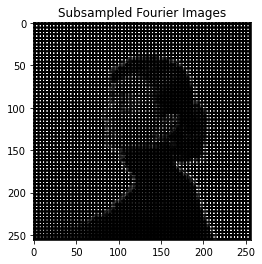

In [ ]:
# 6-(1). Subsampling F's
SubFs = []
for F in Fs:
  SubFs.append(np.dot(SF, np.dot(F, np.matrix.getH(SF))))
SubFs = np.array(SubFs)

# 6-(2) Subsampling 된 푸리에 이미지를 출력한다. 
plt.imshow(abs(GetNxN(SubFs)), cmap='gray', vmin=0, vmax=255 )
plt.title("Subsampled Fourier Images")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


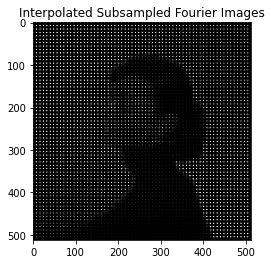

In [ ]:
# 6-(3). Interpolating Subsampled F's
InterSubFs = []
for SubF in SubFs:
  InterSubFs.append(np.dot(IF, np.dot(SubF, np.matrix.getH(IF))))
InterSubFs = np.array(InterSubFs)

# 6-(4) Subsampling -> Interpolating된 푸리에 이미지 출력
plt.imshow(abs(GetNxN(InterSubFs)), cmap="gray", vmin=0, vmax=255 )
plt.title("Interpolated Subsampled Fourier Images")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


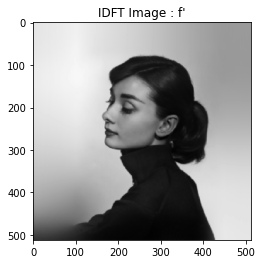

In [ ]:
# 6-(5). IDFT image F's which is interpolated and subsampled
InvInterSubFs = []
IT8 = IT(8)
for isF in InterSubFs:
  InvInterSubFs.append(np.dot(IT8, np.dot(isF, np.matrix.getH(IT8))))
InvInterSubFs = np.array(InvInterSubFs)

# 6-(6). Show IDFT Image
f_processed_frequency = abs(GetNxN(InvInterSubFs))
plt.imshow(f_processed_frequency, cmap='gray', vmin=0, vmax=255 )
plt.title("IDFT Image : f'")
plt.show()

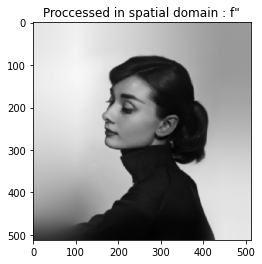

In [ ]:
# 7-(1). Apply S and I to original image in Spatial domain
subfs = []
for f in f_s:
  subfs.append(np.dot(S, np.dot(f, np.transpose(S))))
subfs = np.array(subfs)

intersubfs = []
for sf in subfs:
  intersubfs.append(np.dot(I, np.dot(sf, np.transpose(I))))
intersubfs = np.array(intersubfs)

# 7-(2). Show the image proccessed in spatial domain
f_proccessed_spatial = GetNxN(intersubfs)
plt.imshow(f_proccessed_spatial, cmap='gray', vmin=0, vmax=255 )
plt.title("Proccessed in spatial domain : f\"")
plt.show()

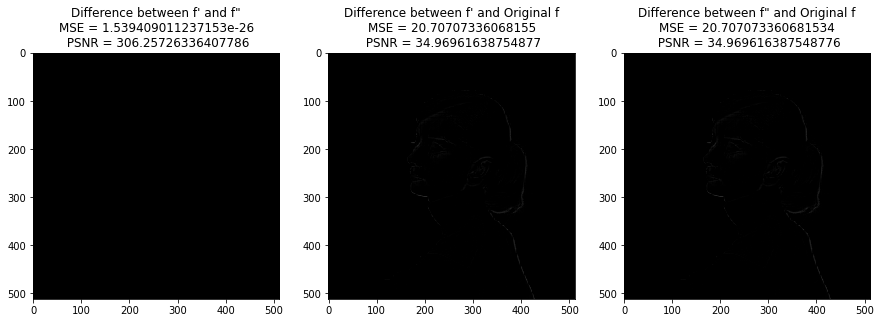

In [ ]:
# Compare with f'(proccessed in frequency domain) and f"(proccessed in spatial domain)
f_diff1 = f_processed_frequency - f_proccessed_spatial
mse1 = np.square(f_diff1).mean(axis=None)
psnr1 = 20 * np.log10(255/np.sqrt(mse1))
error_msg1 = "MSE = {0}\n PSNR = {1}".format(mse1, psnr1)
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(f_diff1, cmap= "gray", vmin=0, vmax=255 )
plt.title("Difference between f' and f\"\n"+ error_msg1)

# Compare with f' and Original Image f
f_diff2 = f_processed_frequency - original_f
mse2 = np.square(f_diff2).mean(axis=None)
psnr2 = 20 * np.log10(255/np.sqrt(mse2))
error_msg2 = "MSE = {0}\n PSNR = {1}".format(mse2, psnr2)
plt.subplot(1, 3, 2)
plt.imshow(f_diff2, cmap= "gray", vmin=0, vmax=255 )
plt.title("Difference between f' and Original f\n"+error_msg2)

# Compare with f" and Original Image f
f_diff3 = f_proccessed_spatial - original_f
mse3 = np.square(f_diff3).mean(axis=None)
psnr3 = 20 * np.log10(255/np.sqrt(mse3))
error_msg3 = "MSE = {0}\n PSNR = {1}".format(mse3, psnr3)
plt.subplot(1, 3, 3)
plt.imshow(f_diff3, cmap= "gray", vmin=0, vmax=255 )
plt.title("Difference between f\" and Original f\n" + error_msg3)
plt.show()